In [4]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.tsa.api import VAR

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, LeakyReLU, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsoluteError
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

pd.reset_option('all')

import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [5]:
#Reading as pandas dataframe
data = pd.read_csv('electricity_demand.csv')

In [6]:
#Viewing the data rows
data.head()

,date,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,1/01/2015,99635.030,25.633696,13.3,26.9,23.6,0.0,N,Y
1,1/02/2015,129606.010,33.138988,15.4,38.8,26.8,0.0,N,N
2,1/03/2015,142300.540,34.564855,20.0,38.2,26.5,0.0,N,N
3,1/04/2015,104330.715,25.005560,16.3,21.4,25.2,4.2,N,N
4,1/05/2015,118132.200,26.724176,15.0,22.0,30.7,0.0,N,N


In [7]:
#Encoding the categorical features in our data
data [['school_day', 'holiday']] = data[['school_day', 'holiday']].apply(LabelEncoder().fit_transform)

In [8]:
#Getting the correlation matrix
data.corr()

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
demand,1.000000,0.228934,-0.152410,-0.066570,-0.275652,-0.067747,0.163933,-0.241669
RRP,0.228934,1.000000,0.059147,0.150755,0.043693,-0.029845,0.008829,-0.031031
min_temperature,-0.152410,0.059147,1.000000,0.697722,0.358368,0.003312,-0.084688,0.064289
max_temperature,-0.066570,0.150755,0.697722,1.000000,0.586511,-0.156384,-0.090167,0.039383
solar_exposure,-0.275652,0.043693,0.358368,0.586511,1.000000,-0.127275,-0.102242,0.041119
rainfall,-0.067747,-0.029845,0.003312,-0.156384,-0.127275,1.000000,-0.021966,-0.011630
school_day,0.163933,0.008829,-0.084688,-0.090167,-0.102242,-0.021966,1.000000,-0.165140
holiday,-0.241669,-0.031031,0.064289,0.039383,0.041119,-0.011630,-0.165140,1.000000


*Since the column demand and demand_pos_RRP have similar values, to avoid redundancy we need to remove the demand_pos_RRP column before building our model, as the demand is our dependent variable and we do not want data leakage in our model. Similarly, we can see that the RRP and the RRP_positive is highly correlated (~0.99), we need to remove one of these features before building our model. As the features RRP is slighly higher correlated with the depedent variable demand, we drop the demand_pos_RRP column.* 

In [9]:
#Check for NA values
data.isnull().sum(axis = 0)

date               0
demand             0
RRP                0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64

*As the columns solar_exposure and rainfall have NA values, we can replace the NA values with the average values of the respective columns.*

In [10]:
#Filing NA values with average values for respective columns  
data.fillna(data.mean(), inplace = True)

In [11]:
#Validating the changes
data.isnull().sum(axis = 0)

date               0
demand             0
RRP                0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64

In [12]:
#Correlation plot
rs = np.random.RandomState(0)
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
demand,1.000000,0.228934,-0.152410,-0.066570,-0.275652,-0.067747,0.163933,-0.241669
RRP,0.228934,1.000000,0.059147,0.150755,0.043693,-0.029845,0.008829,-0.031031
min_temperature,-0.152410,0.059147,1.000000,0.697722,0.358368,0.003312,-0.084688,0.064289
max_temperature,-0.066570,0.150755,0.697722,1.000000,0.586511,-0.156384,-0.090167,0.039383
solar_exposure,-0.275652,0.043693,0.358368,0.586511,1.000000,-0.127275,-0.102242,0.041119
rainfall,-0.067747,-0.029845,0.003312,-0.156384,-0.127275,1.000000,-0.021966,-0.011630
school_day,0.163933,0.008829,-0.084688,-0.090167,-0.102242,-0.021966,1.000000,-0.165140
holiday,-0.241669,-0.031031,0.064289,0.039383,0.041119,-0.011630,-0.165140,1.000000


#Demand feature

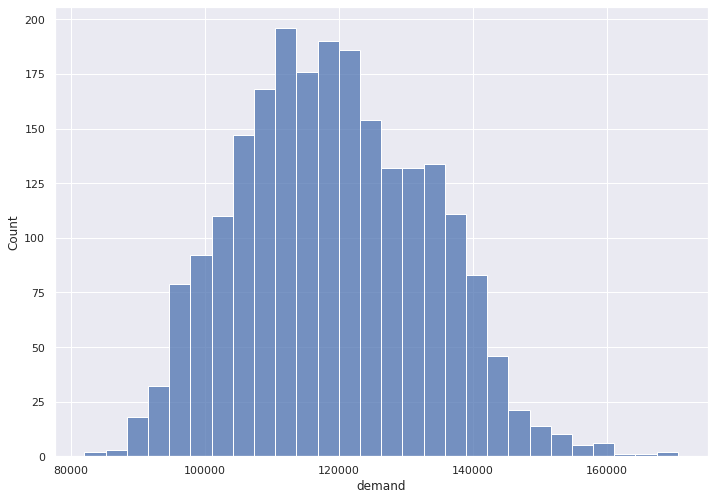

In [13]:
#Histogram of the dependent variable
sns.histplot(data=data, x="demand")

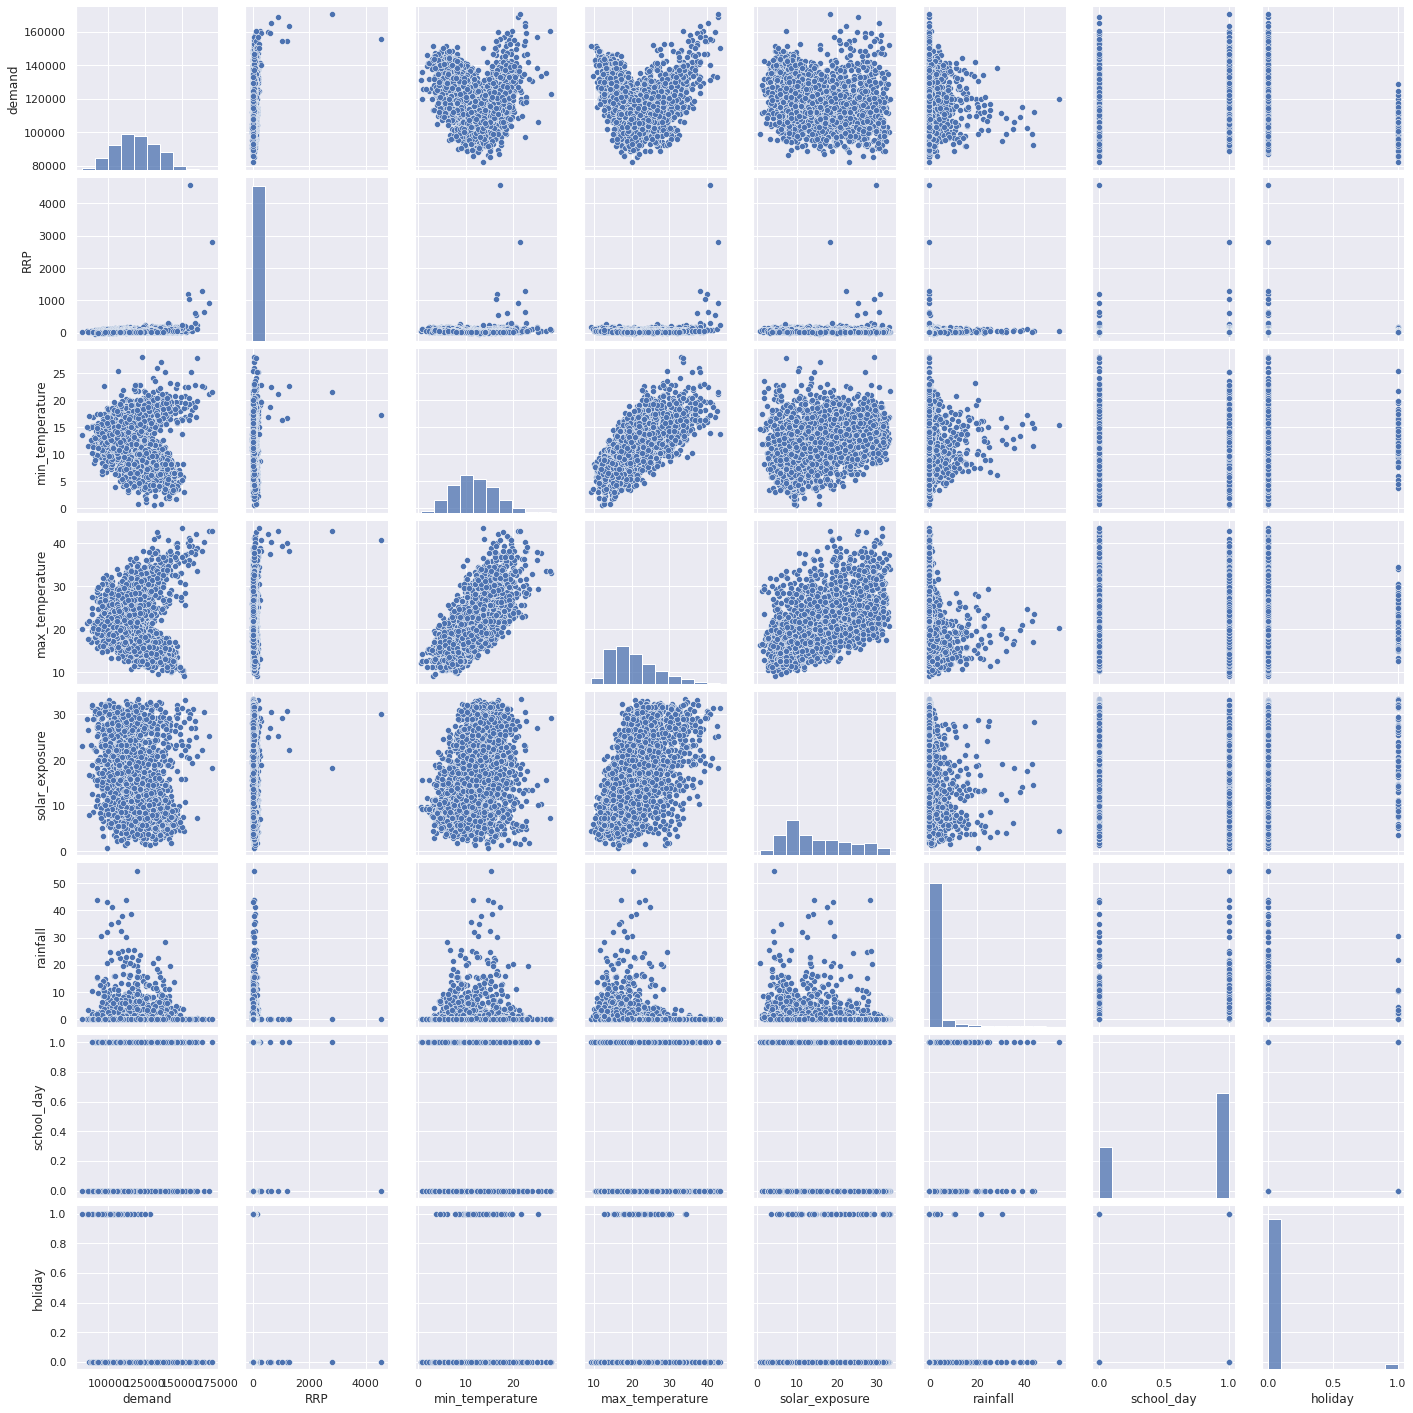

In [ ]:
#Pairplot of the features to understand the trend
sns.pairplot(data, diag_kws={'bins': 10})

In [14]:
#Splitting into indepedent features and dependent features.
x = data[[ 'RRP', 'min_temperature', 'max_temperature',
       'solar_exposure', 'rainfall', 'school_day', 'holiday']]
y = data['demand']

Relevant features using f_regression and mutual info analysis. 

In [15]:
#Identifying relevant features using Feature selection 
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

xy = SelectKBest(f_regression, k = 'all')
xy.fit(x, y)

SelectKBest(k='all', score_func=<function f_regression at 0x7f9306f26170>)

In [16]:
for i in range(7):
  print("The p-value for the variable", x.columns[i],"is", round((xy.pvalues_[i]),4))

The p-value for the variable RRP is 0.0
The p-value for the variable min_temperature is 0.0
The p-value for the variable max_temperature is 0.0016
The p-value for the variable solar_exposure is 0.0
The p-value for the variable rainfall is 0.0013
The p-value for the variable school_day is 0.0
The p-value for the variable holiday is 0.0


In [ ]:
for i in range(7):
  print("The scores for the variable", x.columns[i],"is", round((xy.scores_[i]),4))

The scores for the variable RRP is 124.3908
The scores for the variable min_temperature is 53.4837
The scores for the variable max_temperature is 10.0111
The scores for the variable solar_exposure is 184.94
The scores for the variable rainfall is 10.3698
The scores for the variable school_day is 62.1089
The scores for the variable holiday is 139.497


*With 5% level of significance, we determine that using the ANOVA feature selection, we determine that all variables are relevant in predicting the electricity demand. However, the score for the max temperature and rainfall is very low.*





#Forecast RRP feature using time-series modelling


In [17]:
df = data[['date','min_temperature', 'max_temperature',
       'solar_exposure', 'rainfall', 'school_day', 'holiday', 'RRP']]

In [18]:
len(df)

2251

#Checking for stationarity using the ADFuller test

**Stationarity means that the statistical properties of a process generating a time series do not change over time.**

In [19]:
#Split into x, y
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [20]:
#Convert date to appropriate format
x['date'] = pd.to_datetime(x['date'])
df.drop(columns = ['date'], inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
#Fuller test for checking stationarity in the features
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])
  if result[1] > 0.05:
    print(df.columns[i],"Series is non stationary")
  else: 
    print(df.columns[i], "Stationary")

min_temperature Stationary
max_temperature Series is non stationary
solar_exposure Series is non stationary
rainfall Stationary
school_day Stationary
holiday Stationary
RRP Stationary


#Granger causality test

H0 - X(t) does not granger cause Y(t), previous values of x does not help in forecasting y. 

H1 - X(t) granger causes Y(t) i.e. previous x values help in forecasting y. Here x is the weather features while the y is the RRP.

In [22]:
#Granger causality test between min temperature and RRP 
res = grangercausalitytests(df[['min_temperature', 'RRP']], maxlag=8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3229 , p=0.0008  , df_denom=2247, df_num=1
ssr based chi2 test:   chi2=11.3380 , p=0.0008  , df=1
likelihood ratio test: chi2=11.3095 , p=0.0008  , df=1
parameter F test:         F=11.3229 , p=0.0008  , df_denom=2247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0007  , p=0.0009  , df_denom=2244, df_num=2
ssr based chi2 test:   chi2=14.0325 , p=0.0009  , df=2
likelihood ratio test: chi2=13.9889 , p=0.0009  , df=2
parameter F test:         F=7.0007  , p=0.0009  , df_denom=2244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4084  , p=0.0010  , df_denom=2241, df_num=3
ssr based chi2 test:   chi2=16.2759 , p=0.0010  , df=3
likelihood ratio test: chi2=16.2173 , p=0.0010  , df=3
parameter F test:         F=5.4084  , p=0.0010  , df_denom=2241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7333  , p=0.

Decision - Reject Null hypothesis, meaning previous values of min temp is useful in forecasting RRP.  

In [ ]:
#Granger causality test between max temperature and RRP 
res = grangercausalitytests(df[['max_temperature', 'RRP']], maxlag=8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0263  , p=0.8711  , df_denom=2247, df_num=1
ssr based chi2 test:   chi2=0.0264  , p=0.8710  , df=1
likelihood ratio test: chi2=0.0264  , p=0.8710  , df=1
parameter F test:         F=0.0263  , p=0.8711  , df_denom=2247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8303  , p=0.0030  , df_denom=2244, df_num=2
ssr based chi2 test:   chi2=11.6867 , p=0.0029  , df=2
likelihood ratio test: chi2=11.6564 , p=0.0029  , df=2
parameter F test:         F=5.8303  , p=0.0030  , df_denom=2244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4923  , p=0.0151  , df_denom=2241, df_num=3
ssr based chi2 test:   chi2=10.5095 , p=0.0147  , df=3
likelihood ratio test: chi2=10.4850 , p=0.0149  , df=3
parameter F test:         F=3.4923  , p=0.0151  , df_denom=2241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6514  , p=0.

Decision - Reject Null hypothesis, meaning previous values of max temp is useful in forecasting RRP.  

In [ ]:
#Granger causality test between solar exposure and RRP 
res = grangercausalitytests(df[['solar_exposure', 'RRP']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3662  , p=0.0117  , df_denom=2247, df_num=1
ssr based chi2 test:   chi2=6.3747  , p=0.0116  , df=1
likelihood ratio test: chi2=6.3657  , p=0.0116  , df=1
parameter F test:         F=6.3662  , p=0.0117  , df_denom=2247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5087  , p=0.0111  , df_denom=2244, df_num=2
ssr based chi2 test:   chi2=9.0375  , p=0.0109  , df=2
likelihood ratio test: chi2=9.0194  , p=0.0110  , df=2
parameter F test:         F=4.5087  , p=0.0111  , df_denom=2244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3790  , p=0.0176  , df_denom=2241, df_num=3
ssr based chi2 test:   chi2=10.1688 , p=0.0172  , df=3
likelihood ratio test: chi2=10.1458 , p=0.0174  , df=3
parameter F test:         F=3.3790  , p=0.0176  , df_denom=2241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9419  , p=0.

Decision - Reject Null hypothesis, meaning previous values of solar exposure is useful in forecasting RRP.  

In [ ]:
#Granger causality test between rainfall and RRP 
res = grangercausalitytests(df[['rainfall', 'RRP']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4077  , p=0.5232  , df_denom=2247, df_num=1
ssr based chi2 test:   chi2=0.4082  , p=0.5229  , df=1
likelihood ratio test: chi2=0.4082  , p=0.5229  , df=1
parameter F test:         F=0.4077  , p=0.5232  , df_denom=2247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3836  , p=0.2509  , df_denom=2244, df_num=2
ssr based chi2 test:   chi2=2.7733  , p=0.2499  , df=2
likelihood ratio test: chi2=2.7716  , p=0.2501  , df=2
parameter F test:         F=1.3836  , p=0.2509  , df_denom=2244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0340  , p=0.3764  , df_denom=2241, df_num=3
ssr based chi2 test:   chi2=3.1117  , p=0.3747  , df=3
likelihood ratio test: chi2=3.1095  , p=0.3750  , df=3
parameter F test:         F=1.0340  , p=0.3764  , df_denom=2241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9382  , p=0.

Decision - Fail to reject Null hypothesis, meaning previous values of rainfall is not useful in forecasting RRP.  

#Var Model

In [23]:
#Formatting the dataset
dff = data[['date', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'RRP']]
dff['date'] = pd.to_datetime(dff['date'])

dff.set_index('date', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
#Train-test split
train_data = dff[:int(0.95*(len(dff)))]
test_data = dff[int(0.95*(len(dff))):]

In [25]:
#View the train data
train_data

,min_temperature,max_temperature,solar_exposure,rainfall,RRP
date,,,,,
2015-01-01,13.3,26.9,23.6,0.0,25.633696
2015-01-02,15.4,38.8,26.8,0.0,33.138988
2015-01-03,20.0,38.2,26.5,0.0,34.564855
2015-01-04,16.3,21.4,25.2,4.2,25.005560
2015-01-05,15.0,22.0,30.7,0.0,26.724176
...,...,...,...,...,...
2020-11-03,12.1,30.4,26.9,0.0,41.192083
2020-11-04,21.9,22.8,5.5,0.0,56.009792
2020-11-05,11.1,15.8,23.1,2.8,49.173125


In [ ]:
test_data

,min_temperature,max_temperature,solar_exposure,rainfall
date,,,,
2020-11-08,8.4,19.5,28.9,0.0
2020-11-09,11.3,29.0,28.8,0.0
2020-11-10,16.1,32.0,29.1,0.0
2020-11-11,22.8,28.3,6.5,0.0
2020-11-12,19.3,25.5,20.6,4.0
...,...,...,...,...
2021-02-24,11.6,20.2,23.3,0.0
2021-02-25,10.7,24.3,18.9,0.0
2021-02-26,12.3,19.7,15.7,0.4


In [ ]:
train_data.shape

(2138, 4)

In [ ]:
test_data.shape

(113, 4)

In [ ]:
#Create the VAR instance
var = VAR(train_data, freq = 'D')

In [ ]:
#Fit the model
var_fit= var.fit(maxlags = 15)

In [ ]:
#Model summary
print(var_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Apr, 2021
Time:                     11:37:48
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    10.6064
Nobs:                     2123.00    HQIC:                   10.1940
Log likelihood:          -22373.7    FPE:                    21076.1
AIC:                      9.95583    Det(Omega_mle):         18818.3
--------------------------------------------------------------------
Results for equation min_temperature
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -1.073712         0.318987           -3.366           0.001
L1.min_temperature          0.323454         0.023980           13.488           0.000
L1.max_temperature        

In [ ]:
#Finding the best lag value which gives least AIC for the model
var.select_order(100).summary()

,AIC,BIC,FPE,HQIC
0,12.47,12.48,2.594e+05,12.47
1,10.26,10.31,2.849e+04,10.28
2,10.13,10.23,2.513e+04,10.17
3,10.07,10.22*,2.366e+04,10.12
4,10.03,10.22,2.270e+04,10.10
5,10.00,10.23,2.203e+04,10.09
6,9.986,10.26,2.173e+04,10.09
7,9.971,10.29,2.140e+04,10.09
8,9.946,10.31,2.086e+04,10.08*
9,9.937,10.35,2.069e+04,10.09


In [ ]:
#Building a model based on the best lag value
results = var.fit(11)

In [ ]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Apr, 2021
Time:                     11:38:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    10.4292
Nobs:                     2127.00    HQIC:                   10.1254
Log likelihood:          -22474.1    FPE:                    20952.3
AIC:                      9.94998    Det(Omega_mle):         19269.1
--------------------------------------------------------------------
Results for equation min_temperature
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -1.096247         0.285694           -3.837           0.000
L1.min_temperature          0.322824         0.023848           13.537           0.000
L1.max_temperature        

In [ ]:
lag = results.k_ar

In [ ]:
#Forecast for the next 100 days
forecast_RRP = results.forecast(train_data.values[-lag:], steps = 100)

In [ ]:
test_data

,min_temperature,max_temperature,solar_exposure,rainfall
date,,,,
2020-11-08,8.4,19.5,28.9,0.0
2020-11-09,11.3,29.0,28.8,0.0
2020-11-10,16.1,32.0,29.1,0.0
2020-11-11,22.8,28.3,6.5,0.0
2020-11-12,19.3,25.5,20.6,4.0
...,...,...,...,...
2021-02-24,11.6,20.2,23.3,0.0
2021-02-25,10.7,24.3,18.9,0.0
2021-02-26,12.3,19.7,15.7,0.4


In [ ]:
#Performance of the model on the test set
mean_absolute_error(forecast_RRP[:,4], test_data['RRP'][:100])

KeyError: ignored

In [ ]:
#Performance of the model on the test set
sqrt(mean_squared_error(forecast_RRP[:,4], test_data['RRP'][:100]))

54.46286770543855

In [ ]:
forecast_RRP_df = pd.DataFrame(test_data['RRP'])
forecast_RRP_df = forecast_RRP_df[:100]

In [ ]:
forecast_RRP_df['Forecast_RRP'] = forecast_RRP[:,4]

In [ ]:
#View in a dataframe
forecast_RRP_df

,RRP,Forecast_RRP
date,,
2020-11-08,22.317917,44.850063
2020-11-09,46.335417,53.912942
2020-11-10,41.227500,85.557587
2020-11-11,42.645417,82.665324
2020-11-12,23.034583,67.306025
...,...,...
2021-02-11,28.216458,78.747995
2021-02-12,27.597083,78.717052
2021-02-13,6.259792,78.686312


#Prophet model

In [31]:
#Create our prophet model with 95% confidence interval
prophet = Prophet(interval_width=0.95, seasonality_mode='multiplicative', n_changepoints=23, seasonality_prior_scale=10)

In [32]:
#We need date as an indepedent variable for the prophet model hence we reset our index.
train_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)

In [33]:
train_data

,date,min_temperature,max_temperature,solar_exposure,rainfall,RRP
0,2015-01-01,13.3,26.9,23.6,0.0,25.633696
1,2015-01-02,15.4,38.8,26.8,0.0,33.138988
2,2015-01-03,20.0,38.2,26.5,0.0,34.564855
3,2015-01-04,16.3,21.4,25.2,4.2,25.005560
4,2015-01-05,15.0,22.0,30.7,0.0,26.724176
...,...,...,...,...,...,...
2133,2020-11-03,12.1,30.4,26.9,0.0,41.192083
2134,2020-11-04,21.9,22.8,5.5,0.0,56.009792
2135,2020-11-05,11.1,15.8,23.1,2.8,49.173125
2136,2020-11-06,9.5,16.6,13.2,0.2,58.043333


In [34]:
#For the prophet model, the date variable should be renamed to ds while the value to be forecasted has to renamed as y
train_data.rename({'date':'ds', 'RRP':'y'}, inplace = True, axis = 'columns')
test_data.rename({'date':'ds', 'RRP':'y'}, inplace = True, axis = 'columns')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
#Adding indepedent features to our Univariate model
prophet.add_regressor('min_temperature', standardize=False)
prophet.add_regressor('max_temperature', standardize=False)
prophet.add_regressor('solar_exposure', standardize=False)
prophet.add_regressor('rainfall', standardize=False)

In [36]:
#Training the Multivariate model
prophet.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
#Formatting
test_data_ = test_data.drop(columns = 'y')

In [38]:
#Predict for the test set
future = prophet.predict(test_data)

In [39]:
#Performance metric on the test set 
mean_absolute_error(future['yhat'], test_data['y'])

14.605398649061387

In [ ]:
#Performance of the model on the test set
sqrt(mean_squared_error(future['yhat'], test_data['y']))

17.74249866469692

In [ ]:
df_prophet = pd.DataFrame(test_data['y'])

In [ ]:
df_prophet['Forecast_RRP_'] = future['yhat']

In [ ]:
df_prophet

,y,Forecast_RRP_
0,22.317917,28.386375
1,46.335417,56.293392
2,41.227500,55.125837
3,42.645417,36.514105
4,23.034583,49.956327
...,...,...
108,25.840417,9.048231
109,21.205833,29.112746
110,25.796250,13.483767
111,29.897083,9.057054


#LSTM model

In [ ]:
#Remove date variable 
train_data.drop(columns=['ds'], inplace = True)
test_data.drop(columns=['ds'], inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Split into train and test data 
train_x = train_data.iloc[:,0:4]
train_y = train_data['y']
test_x = test_data.iloc[:,0:4]
test_y = test_data['y']

In [ ]:
#LSTM is sensitive to non-scaled data, hence we scale our data
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
#Create our train and test generator, predictiing RRP based on 30 previous days
win_length = 30
batch_size = 32
num_features = 4

train_generator = TimeseriesGenerator(train_x, train_y, length = win_length, sampling_rate = 1, batch_size = batch_size)
test_generator = TimeseriesGenerator(test_x, test_y, length = win_length, sampling_rate = 1, batch_size = batch_size)

In [ ]:
#Define our LSTM model  
model = Sequential()
model.add(LSTM(128, input_shape= (win_length, num_features), return_sequences=False))
model.add(Dense(1))

In [ ]:
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 128)               68096     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Fit our model on train time series generator
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(loss=MeanSquaredError(),
              optimizer=Adam(),
              metrics=[MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=10,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



66/66 [==============================] - 4s 36ms/step - loss: 9146.8434 - mean_absolute_error: 51.3268 - val_loss: 213.9392 - val_mean_absolute_error: 11.8466
Epoch 2/10
66/66 [==============================] - 2s 29ms/step - loss: 8026.9013 - mean_absolute_error: 36.2910 - val_loss: 236.0655 - val_mean_absolute_error: 11.9236
Epoch 3/10
66/66 [==============================] - 2s 29ms/step - loss: 7607.6875 - mean_absolute_error: 31.3199 - val_loss: 333.9862 - val_mean_absolute_error: 14.3006


In [ ]:
#Evaluate the performance
model.evaluate_generator(test_generator, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



[333.9862365722656, 14.300609588623047]

In [ ]:
#Making predictions
predictions=model.predict(test_generator)
predictions = predictions.ravel()

In [ ]:
#Format data
actual_data = test_y[win_length:]

In [ ]:
#Performance metric of the model
mean_absolute_error(predictions, actual_data)

14.300609780754703

In [ ]:
#Performance metric of the model
sqrt(mean_squared_error(predictions, actual_data))

18.275291263518888

In [ ]:
#Print the predictions
predictions

array([34.275536, 34.27519 , 34.276253, 34.27598 , 34.276165, 34.276703,
       34.276882, 34.277363, 34.277233, 34.276226, 34.276432, 34.27579 ,
       34.276035, 34.276012, 34.275253, 34.275593, 34.27615 , 34.275806,
       34.275845, 34.276585, 34.2756  , 34.27591 , 34.276073, 34.276333,
       34.275143, 34.276707, 34.276073, 34.276752, 34.275135, 34.275482,
       34.27544 , 34.276585, 34.276493, 34.276867, 34.27707 , 34.27727 ,
       34.276207, 34.276203, 34.276104, 34.275333, 34.27532 , 34.276043,
       34.27609 , 34.27597 , 34.27622 , 34.276844, 34.27651 , 34.27664 ,
       34.27705 , 34.277195, 34.275467, 34.276493, 34.275593, 34.275257,
       34.277523, 34.276196, 34.275112, 34.275608, 34.276455, 34.27615 ,
       34.276165, 34.27582 , 34.27553 , 34.275288, 34.27631 , 34.2767  ,
       34.276386, 34.276203, 34.2757  , 34.27554 , 34.276093, 34.276432,
       34.27665 , 34.27691 , 34.276997, 34.27593 , 34.275253, 34.275658,
       34.275585, 34.275757, 34.27572 , 34.275364, 

RRP from March 2021 to August 2021

In [41]:
weather_features = pd.read_csv('predicted_weather_features.csv')

In [42]:
weather_features

,min_temp,max_temp,solar,rainfall
0,12.506416,20.844,14.810004,1.000000
1,12.016535,20.244,15.744815,1.000000
2,11.526654,19.144,15.494148,1.733333
3,11.036772,16.892,13.976392,12.800000
4,10.546891,16.680,13.893853,32.700000
...,...,...,...,...
179,10.412694,17.984,14.492277,0.000000
180,9.922813,19.660,14.623790,0.050000
181,9.432931,21.376,14.505982,1.000000
182,12.378017,20.928,14.810004,1.533333


In [43]:
rng = pd.date_range('2021-03-01', periods=184, freq='D')
weather_features['Date'] = pd.DataFrame({ 'Date': rng}) 
weather_features['Date'] = weather_features['Date'].astype('datetime64[ns]')
weather_features = weather_features[['Date', 'min_temp', 'max_temp', 'solar', 'rainfall']]

In [44]:
weather_features.columns = test_data_.columns

In [45]:
future_ = prophet.predict(weather_features)

In [46]:
data['RRP']

0       25.633696
1       33.138988
2       34.564855
3       25.005560
4       26.724176
          ...    
2246    25.840417
2247    21.205833
2248    25.796250
2249    29.897083
2250    22.412917
Name: RRP, Length: 2251, dtype: float64

In [49]:
RRP = data['RRP']
RRP_ = future_['yhat']

In [50]:
RRP__ = RRP.append(RRP_, ignore_index=True)

In [51]:
rng = pd.date_range('2015-01-01', periods=2435, freq='D')
Dates = pd.DataFrame({ 'Date': rng}) 

In [52]:
Dates

,Date
0,2015-01-01
1,2015-01-02
2,2015-01-03
3,2015-01-04
4,2015-01-05
...,...
2430,2021-08-27
2431,2021-08-28
2432,2021-08-29
2433,2021-08-30


Text(0, 0.5, 'RRP')

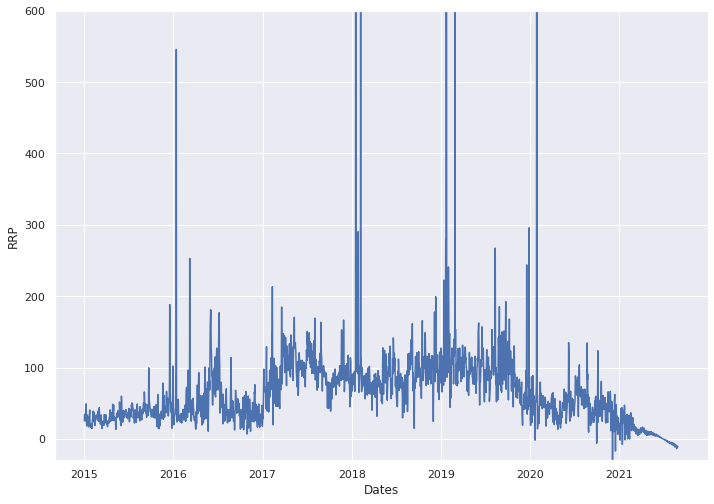

In [69]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(Dates, RRP__)
plt.ylim(-30, 600)
plt.xlabel('Dates')
plt.ylabel('RRP')

In [77]:
pred = pd.DataFrame(Dates)

In [79]:
pred['RRP'] = RRP__

In [86]:
pred['Data'] = 'Actual Data'

In [87]:
pred['Data'][2250:] = 'Predicted Data'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'RRP')

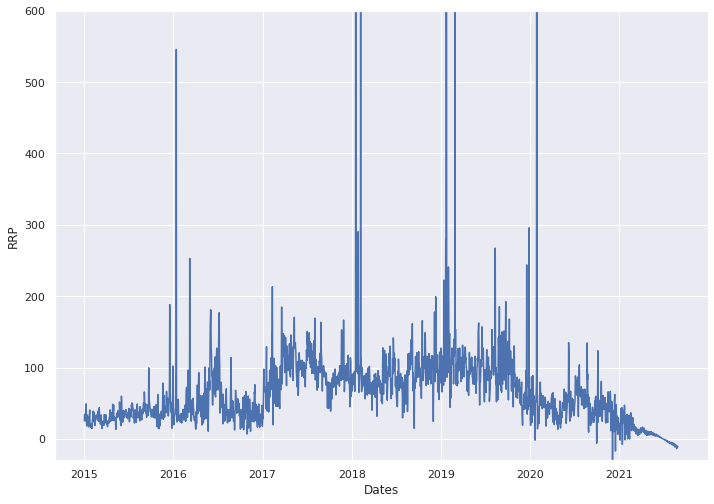

In [88]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.plot(pred['Date'], pred['RRP'])
plt.ylim(-30, 600)
plt.xlabel('Dates')
plt.ylabel('RRP')

Text(0, 0.5, 'RRP')

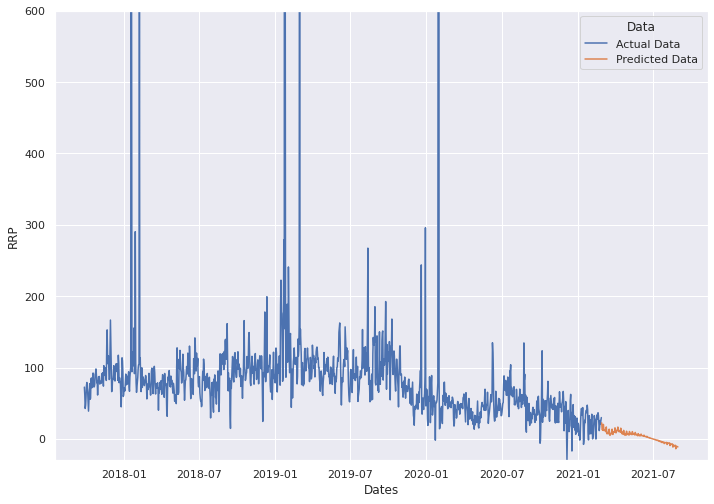

In [93]:
sns.lineplot(pred['Date'][1000:], pred['RRP'][1000:], hue = pred['Data'])
plt.ylim(-30, 600)
plt.xlabel('Dates')
plt.ylabel('RRP')